# Creation of Reliability (Calibration) Diagram Results Figure

Here we will be creating the figure displaying the reliability (i.e., calibration) of the trained models by visualizing forecast probabilities (using a bin size of 0.1) and the associated observed relative frequency. 

The plots also show the climatology of the dataset with a horizontal line. Additional details are contained in the manuscript.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
#from hagelslag.evaluation.ProbabilityMetrics import DistributedReliability

Where the results csv data are stored.

In [2]:
results_directory = '/Users/molina/Desktop/lightning/'

Brier score algebraic decomposition into the resolution, reliability, and uncertainty terms is also performed using a class obtained from the python package Hagelslag (Probability Metrics module), developed by a machine learning scientist at NCAR (David John Gagne): https://github.com/djgagne/hagelslag/blob/master/hagelslag/evaluation/ProbabilityMetrics.py

The class is included below:

In [3]:
"""
Copyright (c) 2015, David John Gagne II. All rights reserved.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

class DistributedReliability(object):
    """
    A container for the statistics required to generate reliability diagrams and calculate the Brier Score.
    DistributedReliabilty objects accept binary probabilistic forecasts and associated observations. The
    forecasts are then discretized into the different probability bins. The total frequency and the frequency
    of positive events for each probability bin are tracked. The Brier Score, Brier Skill Score, and
    Brier score components can all be derived from this information. Like the DistributedROC object,
    DistributedReliability objects can be summed together, and their contents can be output as a string.
    Attributes:
        thresholds (numpy.ndarray): Array of probability thresholds
        obs_threshold (float): Split value (>=) for determining positive observation events
        frequencies (pandas.DataFrame): Stores the total and positive frequencies for each bin
    Examples:
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> rel = DistributedReliability()
        >>> rel.update(forecasts, obs)
        >>> print(rel.brier_score())
        
    """

    def __init__(self, thresholds=np.arange(0, 1.1, 0.05), obs_threshold=1.0, input_str=None):
        """
        Initialize the DistributedReliability object.
        Args:
            thresholds (numpy.ndarray): Array of probability thresholds
            obs_threshold (float): Split value for observations
            input_str (str): String containing information to initialize the object from a text representation.
        """
        self.thresholds = thresholds
        self.obs_threshold = obs_threshold
        self.frequencies = pd.DataFrame(np.zeros((self.thresholds.size, 2), dtype=int),
                                        columns=["Total_Freq", "Positive_Freq"])
        if input_str is not None:
            self.from_str(input_str)

    def update(self, forecasts, observations):
        """
        Update the statistics with a set of forecasts and observations.
        Args:
            forecasts (numpy.ndarray): Array of forecast probability values
            observations (numpy.ndarray): Array of observation values
        """
        for t, threshold in enumerate(self.thresholds[:-1]):
            self.frequencies.loc[t, "Positive_Freq"] += np.count_nonzero((threshold <= forecasts) &
                                                                         (forecasts < self.thresholds[t+1]) &
                                                                         (observations >= self.obs_threshold))
            self.frequencies.loc[t, "Total_Freq"] += np.count_nonzero((threshold <= forecasts) &
                                                                      (forecasts < self.thresholds[t+1]))
    
    def clear(self):
        self.frequencies.loc[:, :] = 0

    def __add__(self, other):
        """
        Add two DistributedReliability objects together and combine their values.
        Args:
            other: a DistributedReliability object
        Returns:
            A DistributedReliability Object
        """
        sum_rel = DistributedReliability(self.thresholds, self.obs_threshold)
        sum_rel.frequencies = self.frequencies + other.frequencies
        return sum_rel

    def merge(self, other_rel):
        """
        Ingest another DistributedReliability and add its contents to the current object.
        Args:
            other_rel: a Distributed reliability object.
        """
        if other_rel.thresholds.size == self.thresholds.size and np.all(other_rel.thresholds == self.thresholds):
            self.frequencies += other_rel.frequencies
        else:
            print("Input table thresholds do not match.")

    def reliability_curve(self):
        """
        Calculates the reliability diagram statistics. The key columns are Bin_Start and Positive_Relative_Freq
        Returns:
            pandas.DataFrame
        """
        total = self.frequencies["Total_Freq"].sum()
        curve = pd.DataFrame(columns=["Bin_Start", "Bin_End", "Bin_Center",
                                      "Positive_Relative_Freq", "Total_Relative_Freq"])
        curve["Bin_Start"] = self.thresholds[:-1]
        curve["Bin_End"] = self.thresholds[1:]
        curve["Bin_Center"] = 0.5 * (self.thresholds[:-1] + self.thresholds[1:])
        curve["Positive_Relative_Freq"] = self.frequencies["Positive_Freq"] / self.frequencies["Total_Freq"]
        curve["Total_Relative_Freq"] = self.frequencies["Total_Freq"] / total
        return curve

    def brier_score_components(self):
        """
        Calculate the components of the Brier score decomposition: reliability, resolution, and uncertainty.
        """
        rel_curve = self.reliability_curve()
        total = self.frequencies["Total_Freq"].sum()
        climo_freq = float(self.frequencies["Positive_Freq"].sum()) / self.frequencies["Total_Freq"].sum()
        reliability = np.sum(self.frequencies["Total_Freq"] * (rel_curve["Bin_Start"] -
                                                               rel_curve["Positive_Relative_Freq"]) ** 2) / total
        resolution = np.sum(self.frequencies["Total_Freq"] * (rel_curve["Positive_Relative_Freq"] - climo_freq) ** 2) \
                     / total
        uncertainty = climo_freq * (1 - climo_freq)
        return reliability, resolution, uncertainty

    def climatology(self):
        """
        Calculates the sample climatological relative frequency of the event being forecast.
        """
        return float(self.frequencies["Positive_Freq"].sum()) / self.frequencies["Total_Freq"].sum()

    def brier_score(self):
        """
        Calculate the Brier Score
        """
        reliability, resolution, uncertainty = self.brier_score_components()
        return reliability - resolution + uncertainty

    def brier_skill_score(self):
        """
        Calculate the Brier Skill Score
        """
        reliability, resolution, uncertainty = self.brier_score_components()
        return (resolution - reliability) / uncertainty

    def __str__(self):
        out_str = "Obs_Threshold:{0:0.2f}".format(self.obs_threshold) + ";"
        out_str += "Thresholds:" + " ".join(["{0:0.2f}".format(t) for t in self.thresholds]) + ";"
        for col in self.frequencies.columns:
            out_str += col + ":" + " ".join(["{0:d}".format(t) for t in self.frequencies[col]]) + ";"
        out_str = out_str.rstrip(";")
        return out_str

    def __repr__(self):
        return self.__str__()

    def from_str(self, in_str):
        """
        Updates the object attributes with the information contained in the input string
        Args:
            in_str (str): String output by the __str__ method containing all of the attribute values
        """
        parts = in_str.split(";")
        for part in parts:
            var_name, value = part.split(":")
            if var_name == "Obs_Threshold":
                self.obs_threshold = float(value)
            elif var_name == "Thresholds":
                self.thresholds = np.array(value.split(), dtype=object)
                self.frequencies = pd.DataFrame(columns=self.frequencies.columns,
                                                data=np.zeros((self.thresholds.size,
                                                              self.frequencies.columns.size)))
            elif var_name in ["Positive_Freq", "Total_Freq"]:
                self.frequencies[var_name] = np.array(value.split(), dtype=object)

Functions used for plots.

In [4]:
def perf_indx(y_actual, y_hat):
    """
    
    Parameters
    ----------
    y_actual : float
        Ground truth.
    y_hat : float
        Model output.

    Returns
    -------
    Indices of TP, FP, FN, TN.

    """
    TP_indx = []
    FP_indx = []
    FN_indx = []
    TN_indx = []
    for i in range(len(y_hat)): 
        # tp
        if y_actual[i]==y_hat[i]==1:
           TP_indx.append(i)
        # fp
        if y_hat[i]==1 and y_actual[i]==0:
           FP_indx.append(i)
        # fn
        if y_hat[i]==0 and y_actual[i]==1:
           FN_indx.append(i)
        # tn
        if y_actual[i]==y_hat[i]==0:
           TN_indx.append(i)

    return(np.array(TP_indx), np.array(FP_indx), 
           np.array(FN_indx), np.array(TN_indx))

def perf_measure(y_actual, y_hat):
    """
    
    Parameters
    ----------
    y_actual : float
        Ground truth.
    y_hat : float
        Model output.

    Returns
    -------
    Frequency of TP, FP, FN, TN.

    """
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_hat)): 
        # tp
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        # fp
        if y_hat[i]==1 and y_actual[i]==0:
           FP += 1
        # fn
        if y_hat[i]==0 and y_actual[i]==1:
           FN += 1
        # tn
        if y_actual[i]==y_hat[i]==0:
           TN += 1
    return(TP, FP, FN, TN)

def grab_values(filename, threshold=0.5, grab_indices=True, 
                directory=results_directory):
    """

    Parameters
    ----------
    filename : string
        Name of file.
    threshold: float.
        Threshold for binary label assignment.
    grab_indices: boolean.
        If true grab tp, tn, etc indices.
        If false grab tp, tn, etc total.

    Returns
    -------
    prob : float
        Model output.
    grnd : float
        Ground truth.
    tpi (tp) : int
        Indices of true positive (or values).
    fpi (fp) : int
        Indices of false positive (or values).
    fni (fn) : int
        Indices of false negative (or values).
    tni (tn) : int
        Indices of true negative (or values).

    """
    # load csv file
    df = pd.read_csv(f'{directory}{filename}')
    # grab class prediction
    prob = df['probability']
    # make class prediction binary
    prob = prob.where(prob>=threshold,0).where(prob<threshold,1)
    # grab ground truth
    grnd = df['ground_truth']
    if grab_indices:
        # assign category
        tpi, fpi, fni, tni = perf_indx(grnd, prob)
        return prob, grnd, tpi, fpi, fni, tni
    if not grab_indices:
        # assign category
        tp, fp, fn, tn = perf_measure(grnd, prob)
        return prob, grnd, tp, fp, fn, tn
    
    
def conf_matrix_hour_freq(tpi, fpi, fni, tni, grnd_hour):
    """

    Parameters
    ----------
    tpi : int
        True positive indices.
    fpi : int
        False positive indices.
    fni : int
        False negative indices.
    tni : int
        True negative indices.
    grnd_hour : int
        Hours of events.

    Returns
    -------
    tphr_freq : int
        Hourly frequencies of tp.
    fphr_freq : int
        Hourly frequencies of fp.
    fnhr_freq : int
        Hourly frequencies of fn.
    tnhr_freq : int
        Hourly frequencies of tn.

    """
    # find tp, tn, etc in ground truth hour data and grab the corresponding event hours
    tphr = grnd_hour[np.isin(grnd_hour.index.values, tpi)]
    fphr = grnd_hour[np.isin(grnd_hour.index.values, fpi)]
    fnhr = grnd_hour[np.isin(grnd_hour.index.values, fni)]
    tnhr = grnd_hour[np.isin(grnd_hour.index.values, tni)]
    
    # rearrange arrays for plotting, fill missing hours with zeros
    tphr_freq = tphr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                tphr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    fphr_freq = fphr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                fphr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    fnhr_freq = fnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                fnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    tnhr_freq = tnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                tnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    return tphr_freq, fphr_freq, fnhr_freq, tnhr_freq


def far_metric(tp, fp):
    """
    
    Parameters
    ----------
    tp : float
        True positive.
    fp : float
        False positive.

    Returns
    -------
    float
        False alarm ratio.

    """
    return fp/(tp + fp)


def csi_metric(tp, fp, fn):
    """

    Parameters
    ----------
    tp : float
        True positive.
    fp : float
        False positive.
    fn : float
        False negative.

    Returns
    -------
    float
        Critical success index.

    """
    return tp/(tp + fp + fn)


def pod_metric(tp, fn):
    """

    Parameters
    ----------
    tp : float
        True positive.
    fn : float
        False negative.

    Returns
    -------
    float
        Probability of detection.

    """
    return tp/(tp + fn)


def pofd_metric(fp, tn):
    """

    Parameters
    ----------
    fp : float
        False positive.
    tn : float
        True negative.

    Returns
    -------
    float
        Probability of false detection.

    """
    return fp/(fp + tn)

Constants for figure.

In [5]:
rel_thresholds = np.arange(0, 1.1, 0.1)

ticks = rel_thresholds 

Figure with five plots showing reliability (calibration) for all five models with 15-min lead time.


1,000 kernel model skill scores
         BS       BSS  reliability  resolution  uncertainty     climo
0  0.225653  0.097314     0.007805    0.032132      0.24998  0.504505

5,000 kernel model skill scores
         BS       BSS  reliability  resolution  uncertainty     climo
0  0.204077  0.183627     0.012762    0.058665      0.24998  0.504505

10,000 kernel model skill scores
         BS       BSS  reliability  resolution  uncertainty     climo
0  0.204752  0.180925     0.027879    0.073106      0.24998  0.504505

50,000 kernel model skill scores
         BS       BSS  reliability  resolution  uncertainty     climo
0  0.208288  0.166779     0.031036    0.072728      0.24998  0.504505

100,000 kernel model skill scores
         BS       BSS  reliability  resolution  uncertainty     climo
0  0.199324  0.202638     0.020783    0.071438      0.24998  0.504505
 


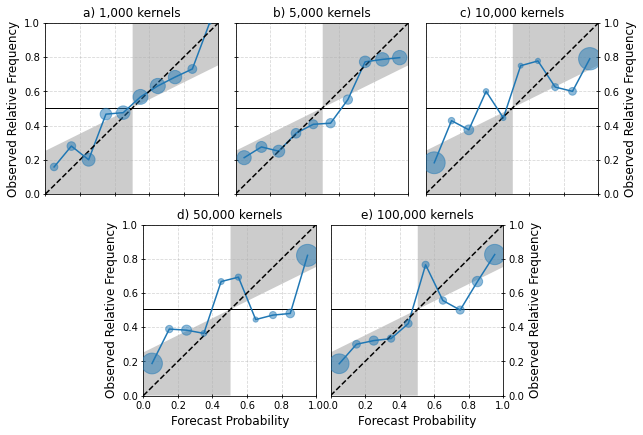

In [6]:
#-----------------------%

# create figure to plot on
fig = plt.figure(figsize=(8.,5.))

#-----------------------%

# first plot
ax1 = fig.add_axes([0.0, 0.5, 0.3, 0.475])

# load csv file
df = pd.read_csv(f'{results_directory}results_paper_1K_predictions.csv')
# grab class prediction
prob = df['probability']
# grab ground truth
grnd = df['ground_truth']

# compute reliability data
rel_things = pd.DataFrame(np.zeros((1, 6), dtype=int),
                          columns=["BS", "BSS", "reliability", "resolution", "uncertainty", "climo"])
rel = DistributedReliability(rel_thresholds)
rel.update(forecasts=prob, observations=grnd)
bs = rel.brier_score()
bss = rel.brier_skill_score()
reliability, resolution, uncertainty=rel.brier_score_components()
climo = rel.climatology()
rel_things.iloc[0] += [bs, bss, reliability, resolution, uncertainty, climo]
df_rc = rel.reliability_curve()
df_fq = rel.frequencies

# print the associated skill scores from 1k model
#print(df_fq)
#print(df_rc)
print("\n1,000 kernel model skill scores")
print(rel_things)

# generate plot data and plot
climo = rel_things['climo'].values
no_skill = 0.5 * ticks + 0.5 * climo
skill_x = [climo[0], climo[0], 1, 1, climo[0], climo[0], 0, 0, climo[0]]
skill_y = [climo[0], 1, 1, no_skill[-1], climo[0], 0, 0, no_skill[0], climo[0]]
f = ax1.fill(skill_x, skill_y, "0.8")
f[0].set_zorder(1)
ax1.plot(ticks, np.ones(ticks.shape) * climo, "k-", lw=1.)
ax1.plot(df_rc['Bin_Center'], df_rc['Positive_Relative_Freq'])
ax1.scatter(df_rc['Bin_Center'], df_rc['Positive_Relative_Freq'], 
            s=df_fq['Total_Freq'].values[:-1]*3, alpha=0.5, zorder=4)
ax1.plot(ticks, ticks, "k--")
ax1.set_title('a) 1,000 kernels', fontsize=12)
ax1.tick_params(axis='both', labelbottom=False, labelleft=True, direction='inout')
ax1.margins(x=0, y=0)
ax1.grid(alpha=0.5, ls='--')
ax1.set_ylabel('Observed Relative Frequency', fontsize=12)

#-----------------------%

ax2 = fig.add_axes([0.33, 0.5, 0.3, 0.475])

# load csv file
df = pd.read_csv(f'{results_directory}results_paper_5K_predictions.csv')
# grab class prediction
prob = df['probability']
# grab ground truth
grnd = df['ground_truth']

# compute reliability data
rel_things = pd.DataFrame(np.zeros((1, 6), dtype=int),
                          columns=["BS", "BSS", "reliability", "resolution", "uncertainty", "climo"])
rel = DistributedReliability(rel_thresholds)
rel.update(forecasts=prob, observations=grnd)
bs = rel.brier_score()
bss = rel.brier_skill_score()
reliability, resolution, uncertainty=rel.brier_score_components()
climo = rel.climatology()
rel_things.iloc[0] += [bs, bss, reliability, resolution, uncertainty, climo]
df_rc = rel.reliability_curve()
df_fq = rel.frequencies

# print the associated skill scores from 5k model
#print(df_fq)
#print(df_rc)
print("\n5,000 kernel model skill scores")
print(rel_things)

# generate plot data and plot
climo = rel_things['climo'].values
no_skill = 0.5 * ticks + 0.5 * climo
skill_x = [climo[0], climo[0], 1, 1, climo[0], climo[0], 0, 0, climo[0]]
skill_y = [climo[0], 1, 1, no_skill[-1], climo[0], 0, 0, no_skill[0], climo[0]]
f = ax2.fill(skill_x, skill_y, "0.8")
f[0].set_zorder(1)
ax2.plot(ticks, np.ones(ticks.shape) * climo, "k-", lw=1.)
ax2.scatter(df_rc['Bin_Center'], df_rc['Positive_Relative_Freq'], 
            s=df_fq['Total_Freq'].values[:-1]*3, alpha=0.5, zorder=4)
ax2.plot(df_rc['Bin_Center'], df_rc['Positive_Relative_Freq'])
ax2.plot(ticks, ticks, "k--")
ax2.set_title('b) 5,000 kernels')
ax2.tick_params(axis='both', labelbottom=False, labelleft=False, direction='inout')
ax2.margins(x=0, y=0)
ax2.grid(alpha=0.5, ls='--')

#-----------------------%

ax3 = fig.add_axes([0.66, 0.5, 0.3, 0.475])

# load csv file
df = pd.read_csv(f'{results_directory}results_paper_10K_predictions.csv')
# grab class prediction
prob = df['probability']
# grab ground truth
grnd = df['ground_truth']

# compute reliability data
rel_things = pd.DataFrame(np.zeros((1, 6), dtype=int),
                          columns=["BS", "BSS", "reliability", "resolution", "uncertainty", "climo"])
rel = DistributedReliability(rel_thresholds)
rel.update(forecasts=prob, observations=grnd)
bs = rel.brier_score()
bss = rel.brier_skill_score()
reliability, resolution, uncertainty=rel.brier_score_components()
climo = rel.climatology()
rel_things.iloc[0] += [bs, bss, reliability, resolution, uncertainty, climo]
df_rc = rel.reliability_curve()
df_fq = rel.frequencies

# print the associated skill scores from 10k model
#print(df_fq)
#print(df_rc)
print("\n10,000 kernel model skill scores")
print(rel_things)

# generate plot data and plot
climo = rel_things['climo'].values
no_skill = 0.5 * ticks + 0.5 * climo
skill_x = [climo[0], climo[0], 1, 1, climo[0], climo[0], 0, 0, climo[0]]
skill_y = [climo[0], 1, 1, no_skill[-1], climo[0], 0, 0, no_skill[0], climo[0]]
f = ax3.fill(skill_x, skill_y, "0.8")
f[0].set_zorder(1)
ax3.plot(ticks, np.ones(ticks.shape) * climo, "k-", lw=1.)
ax3.scatter(df_rc['Bin_Center'], df_rc['Positive_Relative_Freq'], 
            s=df_fq['Total_Freq'].values[:-1]*3, alpha=0.5, zorder=4)
ax3.plot(df_rc['Bin_Center'], df_rc['Positive_Relative_Freq'])
ax3.plot(ticks, ticks, "k--")
ax3.set_title('c) 10,000 kernels')
ax3.tick_params(axis='both', labelbottom=False, labelleft=False, labelright=True, direction='inout')
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.margins(x=0, y=0)
ax3.grid(alpha=0.5, ls='--')
ax3.set_ylabel('Observed Relative Frequency', fontsize=12)

#-----------------------%

ax4 = fig.add_axes([0.17, -0.06,  0.3, 0.475])

# load csv file
df = pd.read_csv(f'{results_directory}results_paper_50K_predictions.csv')
# grab class prediction
prob = df['probability']
# grab ground truth
grnd = df['ground_truth']

# compute reliability data
rel_things = pd.DataFrame(np.zeros((1, 6), dtype=int),
                          columns=["BS", "BSS", "reliability", "resolution", "uncertainty", "climo"])
rel = DistributedReliability(rel_thresholds)
rel.update(forecasts=prob, observations=grnd)
bs = rel.brier_score()
bss = rel.brier_skill_score()
reliability, resolution, uncertainty=rel.brier_score_components()
climo = rel.climatology()
rel_things.iloc[0] += [bs, bss, reliability, resolution, uncertainty, climo]
df_rc = rel.reliability_curve()
df_fq = rel.frequencies

# print the associated skill scores from 50k model
#print(df_fq)
#print(df_rc)
print("\n50,000 kernel model skill scores")
print(rel_things)

# generate plot data and plot
climo = rel_things['climo'].values
no_skill = 0.5 * ticks + 0.5 * climo
skill_x = [climo[0], climo[0], 1, 1, climo[0], climo[0], 0, 0, climo[0]]
skill_y = [climo[0], 1, 1, no_skill[-1], climo[0], 0, 0, no_skill[0], climo[0]]
f = ax4.fill(skill_x, skill_y, "0.8")
f[0].set_zorder(1)
ax4.plot(ticks, np.ones(ticks.shape) * climo, "k-", lw=1.)
ax4.scatter(df_rc['Bin_Center'], df_rc['Positive_Relative_Freq'], 
            s=df_fq['Total_Freq'].values[:-1]*3, alpha=0.5, zorder=4)
ax4.plot(df_rc['Bin_Center'], df_rc['Positive_Relative_Freq'])
ax4.plot(ticks, ticks, "k--")
ax4.set_title('d) 50,000 kernels', fontsize=12)
ax4.margins(x=0, y=0)
ax4.grid(alpha=0.5, ls='--')
ax4.tick_params(axis='both', labelbottom=True, labelleft=True, labelright=False, direction='inout')
ax4.set_ylabel('Observed Relative Frequency', fontsize=12)
ax4.set_xlabel('Forecast Probability', fontsize=12)

#-----------------------%

ax5 = fig.add_axes([0.495, -0.06,  0.3, 0.475])

# load csv file
df = pd.read_csv(f'{results_directory}results_paper_100K_predictions.csv')
# grab class prediction
prob = df['probability']
# grab ground truth
grnd = df['ground_truth']

# compute reliability data
rel_things = pd.DataFrame(np.zeros((1, 6), dtype=int),
                          columns=["BS", "BSS", "reliability", "resolution", "uncertainty", "climo"])
rel = DistributedReliability(rel_thresholds)
rel.update(forecasts=prob, observations=grnd)
bs = rel.brier_score()
bss = rel.brier_skill_score()
reliability, resolution, uncertainty=rel.brier_score_components()
climo = rel.climatology()
rel_things.iloc[0] += [bs, bss, reliability, resolution, uncertainty, climo]
df_rc = rel.reliability_curve()
df_fq = rel.frequencies

# print the associated skill scores from 100k model
#print(df_fq)
#print(df_rc)
print("\n100,000 kernel model skill scores")
print(rel_things)
print(" ")

# generate plot data and plot
climo = rel_things['climo'].values
no_skill = 0.5 * ticks + 0.5 * climo
skill_x = [climo[0], climo[0], 1, 1, climo[0], climo[0], 0, 0, climo[0]]
skill_y = [climo[0], 1, 1, no_skill[-1], climo[0], 0, 0, no_skill[0], climo[0]]
f = ax5.fill(skill_x, skill_y, "0.8")
f[0].set_zorder(1)
ax5.plot(ticks, np.ones(ticks.shape) * climo, "k-", lw=1.)
ax5.scatter(df_rc['Bin_Center'], df_rc['Positive_Relative_Freq'], 
            s=df_fq['Total_Freq'].values[:-1]*3, alpha=0.5, zorder=4)
ax5.plot(df_rc['Bin_Center'], df_rc['Positive_Relative_Freq'])
ax5.plot(ticks, ticks, "k--")
ax5.set_title('e) 100,000 kernels')
ax5.margins(x=0, y=0)
ax5.grid(alpha=0.5, ls='--')
ax5.tick_params(axis='both', labelbottom=True, labelleft=False, labelright=True, direction='inout')
ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()
ax5.set_ylabel('Observed Relative Frequency', fontsize=12)
ax5.set_xlabel('Forecast Probability', fontsize=12)

#-----------------------%

#plt.savefig(f'{results_directory}reliability.png', bbox_inches='tight', dpi=500)
plt.show()

#-----------------------%